
# Zcash Observatory data

Mitchell Krawiec-Thayer and Pranav Thirunavukkarasu

June 2020

Observatory R & D at Insight supported by the Zcash Foundation


## Settings for this notebook

In [1]:
path_to_files = '.'
savedata = 1
remove_sync_hack = 0

## Import libraries

In [2]:
import numpy as np;
import matplotlib.pyplot as plt;
import pandas as pd;
import math;
import os;

## Define functions

In [3]:
# This creates heatmap visualizations

def Heatmap(x, y, LinBins = (60,60), LogBins = (60,60), title = '', xlabel = '', ylabel = '', yscale = 'linear', xscale = 'linear', onlyplot = '', vmax = 'auto', vmin = 0, clabel='', ymax = 'auto'):
    # import numpy as np
    # import matplotlib.pyplot as plt
    # MPKT 2019.06

    # Note that this is a hacky function that cannot handle NaNs at the moment
    
    if ymax == 'auto':
        ymax_val = np.log10(int(np.max(x)))
    else:
        ymax_val = np.log10(int(ymax))
    
    # Log plot
    if not onlyplot == 'linear':
        fig = plt.figure(figsize=(15,5), facecolor='white')
        if len(LogBins) == 2:
            yedges = np.logspace(np.log10(1),ymax_val, LogBins[1])
        H, xedges, yedges = np.histogram2d(list(x),list(y), bins=(LogBins[1],yedges))
        
        # H needs to be rotated and flipped
        H = np.rot90(H)
        H = np.flipud(H)
        
        if vmax == 'auto':
            vmax = np.max(H)
        # Plot 2D histogram using pcolor
        plt.pcolormesh(xedges,yedges,H,vmax=vmax, vmin=vmin)
        cbar = plt.colorbar()
        cbar.ax.set_ylabel(clabel)                                          
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.xscale(xscale)
        plt.yscale(yscale)
        plt.show()
        
        return fig;

## Import data
Assumes that data is in directories named by node ID (location)

In [4]:
# What are the nearby directories
folders = [x[0] for x in os.walk(path_to_files)]

In [39]:
# Initialize
node_names = list()
height_buffer_df = pd.DataFrame()
first_time = 1

# Iterate over nodes
for f in range(len(folders)):
    this_folder_raw = folders[f]
    if not (this_folder_raw[0:3] == './.' or this_folder_raw == '.'):
        node_name = this_folder_raw[2::]
        node_names.append(node_name)
        
        # Import timestamp data
        file_name = os.path.join(this_folder_raw,'inv_v1.csv')
        this_df = pd.read_csv(file_name, index_col = 'Hash')
                
        # Import height data
        blocks_file_name = os.path.join(this_folder_raw,'blocks_v1.csv')
        temp_block_df = pd.read_csv(blocks_file_name, index_col = 'Hash')
        temp_block_df = temp_block_df.filter(["Hash", "Height"], axis=1)
        height_buffer_df = height_buffer_df.append(temp_block_df)
        
        # Join heights
        x = this_df.join(temp_block_df, on='Hash') # temp hook
        
        # Calculate some times and differences
        min_time = this_df.groupby('Hash').min()
        min_time = min_time.rename(columns={"Validated_Time": node_name+"_min", "Peer_IP": "min_IP", "Hash":'block_hash'})
        max_time = this_df.groupby('Hash').max()
        max_time = max_time.rename(columns={"Validated_Time": node_name+"_max", "Peer_IP": "max_IP", "Hash":'block_hash'})
        single_node_combined = pd.concat([min_time, max_time], axis=1)
        single_node_combined[node_name+'_prop_time'] = single_node_combined[node_name+'_max']-single_node_combined[node_name+'_min']
        single_node_combined = single_node_combined.filter(['block_hash', node_name+"_min", node_name+"_max",node_name+"_prop_time"], axis=1)
        
        # Track results
        if first_time:
            global_df = single_node_combined
            first_time = 0
        else:
            global_df = pd.concat([global_df,single_node_combined], axis=1, sort=False)
            
# Join with heights
global_df = pd.concat([global_df, height_buffer_df.drop_duplicates()], axis=1, sort=False)

# Print sample set size and take a peek at the data
print("Number of blocks: " + str(len(global_df)))
global_df.head()

Number of blocks: 7113


,mumbai_min,mumbai_max,mumbai_prop_time,virginia_min,virginia_max,virginia_prop_time,london_min,london_max,london_prop_time,africa_min,africa_max,africa_prop_time,Height
0000000000005cfdaf50e186453b35cd8750605530ef78a2742fe01e05a099d0,1.590804e+09,1.590874e+09,70291.503,1.590804e+09,1.590874e+09,70291.461,1.590804e+09,1.590878e+09,74607.497,1.590804e+09,1.590874e+09,70291.196,848684.0
0000000000008b69454b120e213cc12c70506c97a67882fbbf59e8b439e57fbf,1.591126e+09,1.591126e+09,6.417,1.591126e+09,1.591150e+09,24005.140,1.591126e+09,1.591209e+09,82909.165,1.591126e+09,1.591126e+09,76.542,852983.0
000000000000987f4b5e8ee01c5523d4d532458bdac6f4c520457fbe967eaa37,1.591122e+09,1.591122e+09,4.652,1.591122e+09,1.591150e+09,28261.717,1.591122e+09,1.591150e+09,28261.618,1.591122e+09,1.591122e+09,4.590,852915.0
0000000000009981e955098743bba9eda5a729dc1f3f5f49622881046e065ee5,1.590944e+09,1.590944e+09,26.869,1.590944e+09,1.590944e+09,27.001,1.590944e+09,1.590944e+09,26.991,1.590944e+09,1.590944e+09,26.975,850563.0
0000000000009cae3f28a1512231d476fa15062f2963a04f526f7030bf4125e8,1.590975e+09,1.591044e+09,69228.374,1.590975e+09,1.590975e+09,98.767,1.590975e+09,1.590975e+09,15.838,1.590975e+09,1.591044e+09,69228.150,850963.0


In [47]:
x.head()

,Peer_IP,Validated_Time,Height
Hash,,,
00000000021862efce7b23fe87267fed94dd6722e6a9e21546d4d8d4d37e7dee,5.79.123.194,1.590697e+09,847281
00000000021862efce7b23fe87267fed94dd6722e6a9e21546d4d8d4d37e7dee,5.9.7.62,1.590697e+09,847281
00000000021862efce7b23fe87267fed94dd6722e6a9e21546d4d8d4d37e7dee,3.19.66.87,1.590697e+09,847281
00000000021862efce7b23fe87267fed94dd6722e6a9e21546d4d8d4d37e7dee,120.78.209.151,1.590697e+09,847281
000000000152d63d53347bbbc6f21331f93340bb08c925ffbff9e6358b944c72,47.94.251.211,1.590697e+09,847282


In [59]:
peers = list(set(x['Peer_IP']))

for p in range(3): # range(len(peers)):
    df1 = x[x['Peer_IP'] == peers[p]]
    
df1.head()

,Peer_IP,Validated_Time,Height
Hash,,,
00000000021862efce7b23fe87267fed94dd6722e6a9e21546d4d8d4d37e7dee,3.19.66.87,1.590697e+09,847281
000000000152d63d53347bbbc6f21331f93340bb08c925ffbff9e6358b944c72,3.19.66.87,1.590697e+09,847282
00000000007fe17fadca8304a16bb668f38da57f4a7857a145643a456f5501ad,3.19.66.87,1.590697e+09,847283
00000000018c8d046cd0442f0fc6893dab51bb0c436fa8693705362bd368495e,3.19.66.87,1.590697e+09,847284
00000000013adbb3eea273e7e977a70b2bef2866e58e811ff3fd7694cdb1963b,3.19.66.87,1.590697e+09,847285


## Feature engineering

In [8]:
# initialize empty buffers
prop_list = list()
min_list = list()
max_list = list()

# Loop over heights
for h in range(len(global_df)):
    min_stamps = list()
    max_stamps = list()
    keep_data = 1
    
    # Loop over nodes
    for loc_ind in range(len(node_names)):
        min_val_col = global_df[node_names[loc_ind]+"_min"]
        min_val = min_val_col[h]
        min_stamps.append(min_val)
        max_val_col = global_df[node_names[loc_ind]+"_max"]
        max_val = max_val_col[h]
        max_stamps.append(max_val)
        
        ############
        # FILTERING
        ###########
        
        # Filter 1
        # throw out if any node only heard from one peer
        # (toggle off by commenting out logic block)
        # MPKT note: This might be unnecessary, but doesn't hurt
        if max_val - min_val == 0:
            keep_data = 0 # throw out if any node only heard from ONE peer
        
        # Filter 2
        # throw out if ANY node did not hear the block
        # (toggle off by commenting out logic block)
        if math.isnan(max_val):
            keep_data = 0 
    
    # Keep track 
    global_min = min(min_stamps)
    min_list.append(global_min)
    global_max = max(max_stamps)
    max_list.append(global_max)
    global_prop = global_max - global_min
    
    if keep_data:
        prop_list.append(global_prop)
    else:
        prop_list.append(np.nan)
    
# Transfer from bufffers to data frame
global_df['global_min'] = min_list
global_df['global_max'] = max_list
global_df['global_prop_time'] = prop_list;

## Clean up the data

In [9]:
# Remove NaNs
global_df = global_df[global_df['global_prop_time']>0]
global_df_clean = global_df.dropna();
global_df_clean = global_df_clean.sort_values(by='Height')
print("Number of blocks: " + str(len(global_df)))

Number of blocks: 7080


In [10]:
temp_clean = global_df_clean

### Hacky sync fix

To eliminate artifacts from syncing nodes, we can throw out any data point whose prop time was less than the data point before it.

Assuming that the prop time of block N+1 doesn't depend on prop time of block N (which I believe to be true) then there's a 50/50 chance that a prop_time(N+1) < prop_time(N)

And for a sync, there's 100% chance that prop_time(N+1) < prop_time(N)

So if we throw out every data point that satisfies "prop_time(N+1) < prop_time(N)" we will eliminate 100% of the artifacts, and 50% of the legit data points

This is statistical duct tape and should be replaced with a better method, but for now it should remove artifacts from the data set without introducing bias.

In [11]:
global_df_clean = temp_clean
hack_epsilon = 0
print("Sample size: " + str(len(global_df_clean)))

if remove_sync_hack:
    
    ## Show extant data
    fig = plt.figure(figsize=(10,5), facecolor='w')
    plt.scatter(x=global_df_clean['Height'], y=global_df_clean['global_prop_time'], color='red')
    plt.xlabel('PRE FILTER')
    plt.ylabel('Global propagation time (ms)')
    plt.title('Observed block propagation time ('+str(len(node_names))+' global nodes)');
    
    temp_df = global_df_clean.diff()
    global_df_clean = global_df_clean[temp_df['global_prop_time']>hack_epsilon]
    
    plt.scatter(x=global_df_clean['Height'], y=global_df_clean['global_prop_time'], color='blue')

    print("Sample size: " + str(len(global_df_clean)))

Sample size: 7053


## Review data 

## Visualize data

### Probability density function plot

First, let's look at histograms of the global propagation time.

The first plot uses linear axes, and the second plot shows the same thing with log axes.

This is called the "probability density function" (PDF)

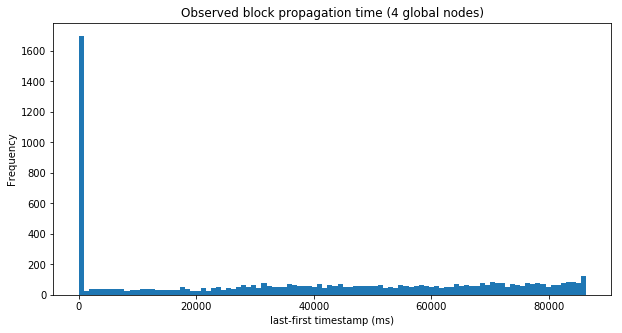

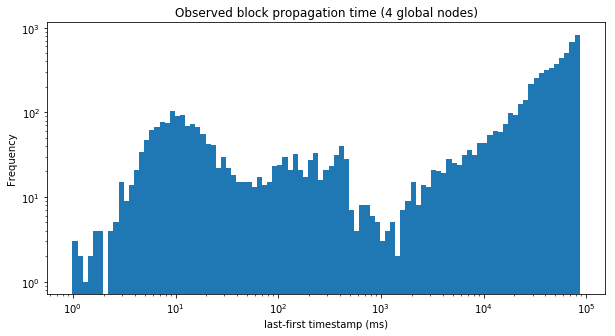

In [12]:
# Linear plot
height_hist = plt.figure(figsize=(10,5), facecolor='w')
plt.hist(global_df_clean['global_prop_time'], bins=100)
plt.xlabel('last-first timestamp (ms)')
plt.ylabel('Frequency')
plt.title('Observed block propagation time (4 global nodes)')

# Log plot
height_hist = plt.figure(figsize=(10,5), facecolor='w')
plt.hist(global_df_clean['global_prop_time'], bins=np.logspace(np.log10(min(global_df_clean['global_prop_time'][global_df_clean['global_prop_time']>0])),np.log10(max(global_df_clean['global_prop_time'])), 100) );plt.yscale('log')
plt.xscale('log')
plt.xlabel('last-first timestamp (ms)')
plt.ylabel('Frequency')
plt.title('Observed block propagation time (4 global nodes)');

### Cumulative distribution function plot

Now let's look at a closely-related plot, the "cumulative distribution function" (CDF)

Crosshairs have been added to show how to interpret this plot. (Note that when the data are updated, the static crosshairs may not match up with the plot / data anymore)

For a given crosshair, <y-axis coordinate> fraction of blocks propagate in under <x-axis coordinate> seconds
    
Black line shows that 50% of blocks propagate in under 20 ms. Red line shows that 85% of blocks propagate in under 300 ms (meaning that 15% of Zcash blocks take more than 800 ms to propagate)

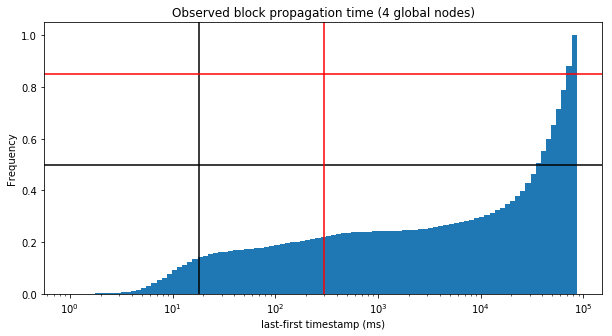

In [13]:
# Generate plot

height_hist = plt.figure(figsize=(10,5), facecolor='w')
plt.hist(global_df_clean['global_prop_time'], bins=np.logspace(np.log10(min(global_df_clean['global_prop_time'][global_df_clean['global_prop_time']>0])),np.log10(max(global_df_clean['global_prop_time'])), 100), cumulative=True, density=True);
#plt.yscale('log')
plt.xscale('log')
plt.xlabel('last-first timestamp (ms)')
plt.ylabel('Frequency')
plt.title('Observed block propagation time (4 global nodes)')


# Add labels to explain
plt.axvline(x=18, color='black')
plt.axhline(y=0.5, color='black')
plt.axvline(x=300, color='red')
plt.axhline(y=0.85, color='red');

### Scatter plot

Now let's plot each block as a dot where x-axis is the block height, and y-axis is the observed global propagation time

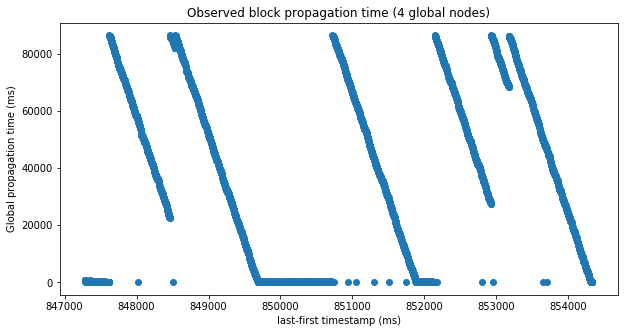

In [14]:
fig = plt.figure(figsize=(10,5), facecolor='w')
plt.scatter(x=global_df_clean['Height'], y=global_df_clean['global_prop_time'])
plt.xlabel('last-first timestamp (ms)')
plt.ylabel('Global propagation time (ms)')
plt.title('Observed block propagation time ('+str(len(node_names))+' global nodes)');

Ah, we see these downward-sloping strings of blocks when the "last" timestamp is from a node that booted up later and requested old blocks. Thus, these are anomalous data points (not representative of propagation time *at time of broadcast*) so we should figure out a way to filter these out. Let's zoom in to see the real propagation times

(0, 80)

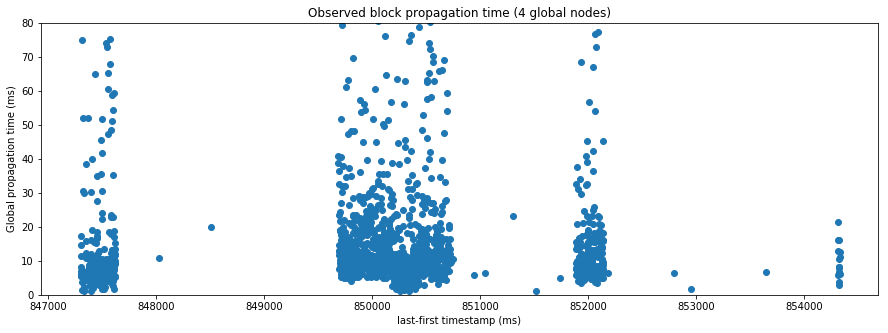

In [15]:
height_hist = plt.figure(figsize=(15,5), facecolor='w')
plt.scatter(x=global_df_clean['Height'], y=global_df_clean['global_prop_time'])
plt.xlabel('last-first timestamp (ms)')
plt.ylabel('Global propagation time (ms)')
plt.title('Observed block propagation time ('+str(len(node_names))+' global nodes)');
plt.ylim([0,80])

# Optional, add lines:
# tempdf = global_df_clean.sort_values(by='Height')
# plt.plot(tempdf['Height'], tempdf['global_prop_time'],color='gray', linewidth=1, linestyle='dashed');

### Heatmap plots
(same concept as the scatter plots above, except shaded)

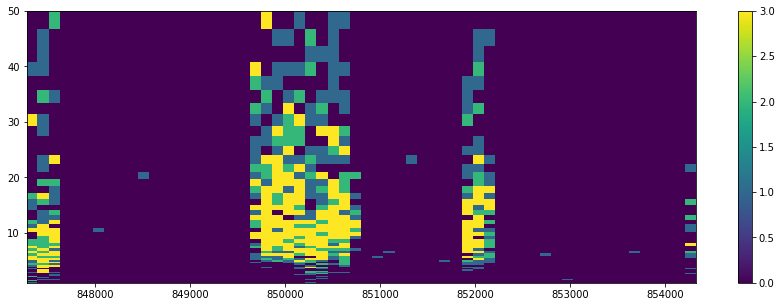

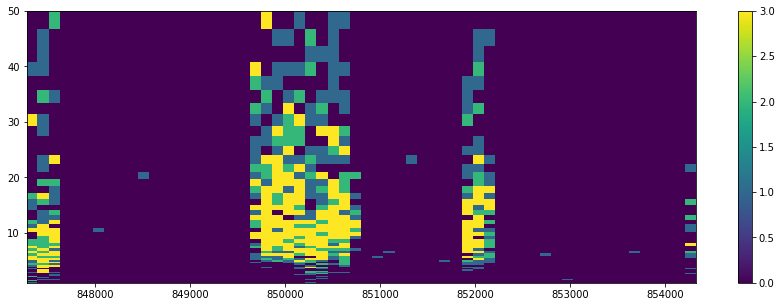

In [16]:
Heatmap(x=global_df_clean['Height'], y=global_df_clean['global_prop_time'], ymax=50, vmax=3)

## Save data
Data frame to CSV if desired

In [17]:
if savedata:
    global_df_clean.to_csv('global_df_clean.csv', index_label = 'block_hash')